# Install and load all libraries

In [ ]:
#|default_exp ml_utils

In [1]:
#|export
from fastai.vision.all import *
import gc

In [19]:
from nbdev.export import nb_export

# Loading data and a bit of preprocessing

#### Loading df and extracting labels for robotic arms

In [3]:
#|export
images_df=pd.read_csv('data/images_df_final.csv', dtype={'image_id':str,'clip_name':str,'labels':str})

In [3]:
#|export

def y1_labeller(i): return re.sub(r"[\[\]]",'',i).split(',')[0].strip()
def y2_labeller(i): return re.sub(r"[\[\]]",'',i).split(',')[1].strip()
def y3_labeller(i): return re.sub(r"[\[\]]",'',i).split(',')[2].strip()
def y4_labeller(i): return re.sub(r"[\[\]]",'',i).split(',')[3].strip()

images_df['y1_label'] = images_df.labels.map(y1_labeller)
images_df['y2_label'] = images_df.labels.map(y2_labeller)
images_df['y3_label'] = images_df.labels.map(y3_labeller)
images_df['y4_label'] = images_df.labels.map(y4_labeller)

In [3]:
images_df.head()

,image_id,clip_name,labels,valid,y1_label,y2_label,y3_label,y4_label
0,data/train_images_c/clip_000000/00390.jpg,clip_000000,"needle_driver,nan,needle_driver,cadiere_forceps",False,needle_driver,nan,needle_driver,cadiere_forceps
1,data/train_images_c/clip_000000/01665.jpg,clip_000000,"needle_driver,nan,needle_driver,cadiere_forceps",False,needle_driver,nan,needle_driver,cadiere_forceps
2,data/train_images_c/clip_000000/01290.jpg,clip_000000,"needle_driver,nan,needle_driver,cadiere_forceps",False,needle_driver,nan,needle_driver,cadiere_forceps
3,data/train_images_c/clip_000000/00885.jpg,clip_000000,"needle_driver,nan,needle_driver,cadiere_forceps",False,needle_driver,nan,needle_driver,cadiere_forceps
4,data/train_images_c/clip_000000/01755.jpg,clip_000000,"needle_driver,nan,needle_driver,cadiere_forceps",False,needle_driver,nan,needle_driver,cadiere_forceps


### Splitter

In [4]:
#|export
def splitter(df):
    train = df.index[~df['valid']].to_list()
    valid = df.index[df['valid']].to_list()
    return train, valid

# Creating the dataloaders

In [5]:
# def get_dblock(item_tfms, batch_tfms):
    
#     dblock = DataBlock(
#         blocks=(ImageBlock,CategoryBlock(),CategoryBlock(),CategoryBlock(),CategoryBlock()),
#         n_inp=1,
#         get_x=ColReader('image_id'),
#         get_y=[ColReader('y1_label'),ColReader('y2_label'),ColReader('y3_label'),ColReader('y4_label')],
#         splitter=splitter,
#         item_tfms=item_tfms,
#         batch_tfms=batch_tfms)
    
#     return dblock

# dblock = get_dblock(item_tfms=Resize((360,640), method='squish'), batch_tfms=aug_transforms(size=(360,640), min_scale=1))
# dls = dblock.dataloaders(images_df, seed=42, n_workers=8)

In [7]:
# Created datablock first and the used the following query to get all tools
# tools_list=list(set(sorted(flatten(dls.vocab)))); tools_list

['cadiere_forceps',
 'prograsp_forceps',
 'bipolar_forceps',
 'force_bipolar',
 'monopolar_curved_scissors',
 'tip_up_fenestrated_grasper',
 'nan',
 'grasping_retractor',
 'needle_driver',
 'bipolar_dissector',
 'stapler',
 'vessel_sealer',
 'clip_applier',
 'permanent_cautery_hook_spatula',
 'blank',
 'suction_irrigator']

In [ ]:
#|export
vocab=['cadiere_forceps',
       'prograsp_forceps',
       'bipolar_forceps',
       'force_bipolar',
       'monopolar_curved_scissors',
       'tip_up_fenestrated_grasper',
       'nan',
       'grasping_retractor',
       'needle_driver',
       'bipolar_dissector',
       'stapler',
       'vessel_sealer',
       'clip_applier',
       'permanent_cautery_hook_spatula',
       'blank',
       'suction_irrigator']

In [10]:
#|export
def get_dblock(item_tfms, batch_tfms):
    
    dblock = DataBlock(
        blocks=(ImageBlock,CategoryBlock(vocab=vocab),CategoryBlock(vocab=vocab),CategoryBlock(vocab=vocab),CategoryBlock(vocab=vocab)),
        n_inp=1,
        get_x=ColReader('image_id'),
        get_y=[ColReader('y1_label'),ColReader('y2_label'),ColReader('y3_label'),ColReader('y4_label')],
        splitter=splitter,
        item_tfms=item_tfms,
        batch_tfms=batch_tfms
    )
    
    return dblock

dblock = get_dblock(item_tfms=Resize((180,320), ResizeMethod.Squish), batch_tfms=[*aug_transforms(size=(180,320), min_scale=1),Normalize.from_stats(*imagenet_stats)])
dls = dblock.dataloaders(images_df, seed=42, n_workers=32)


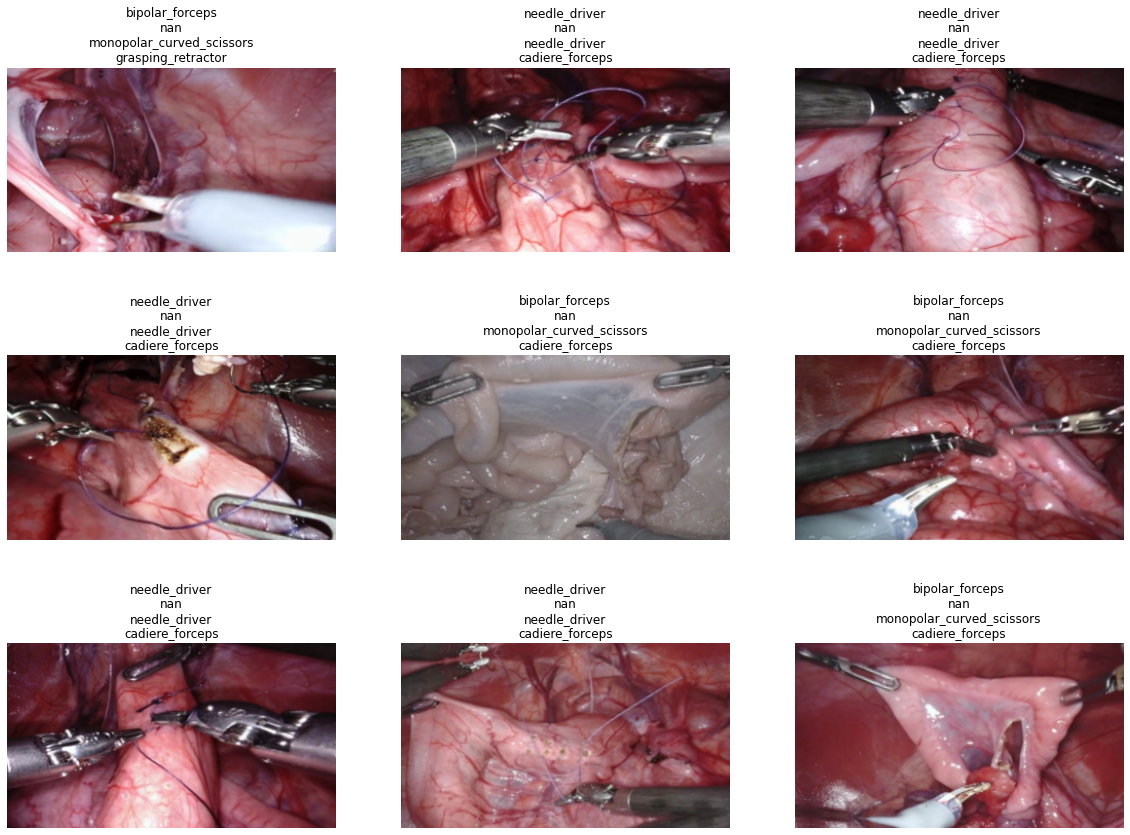

In [10]:
dls.show_batch(figsize=(20,15))

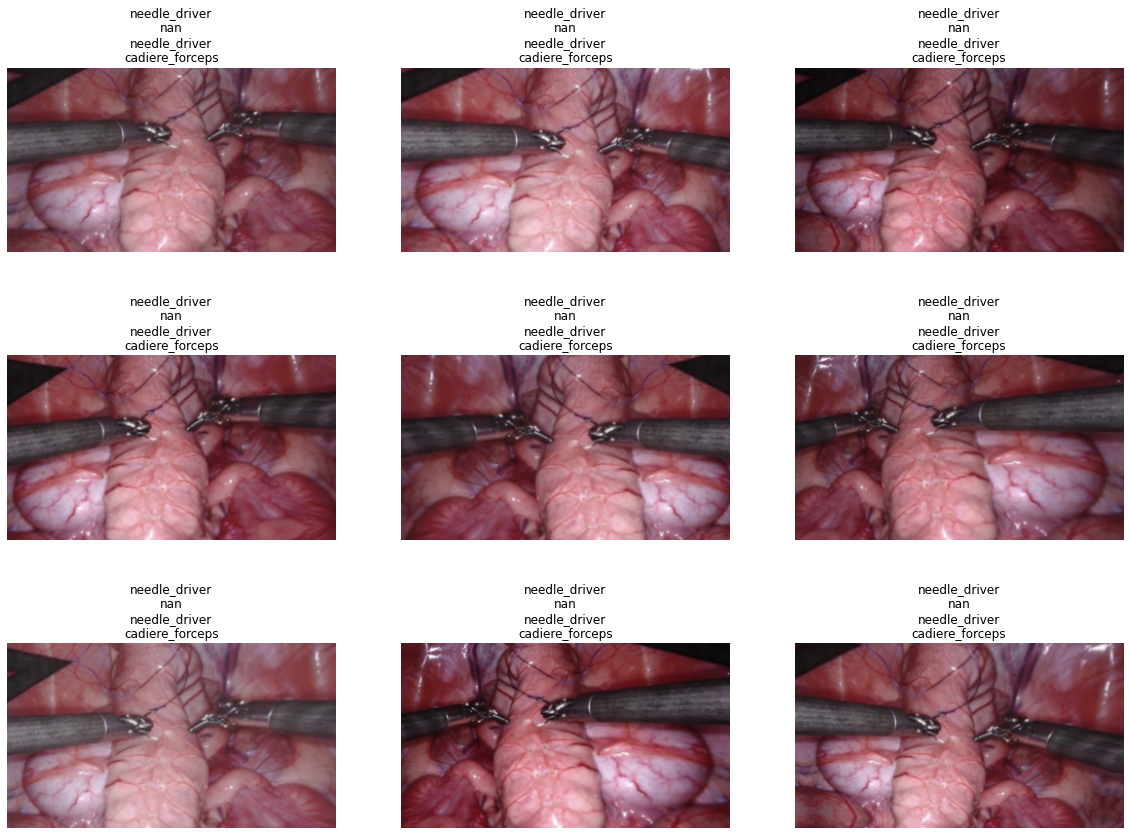

In [11]:
dls.show_batch(unique=True, figsize=(20,15))

# Defining loss functions and metrics

In [12]:
#|export
def cfg (i): return dls.c[:i].sum()

# defining error rate for each robotic hand tools
def usm1_err(preds,usm1_targs,usm2_targs,usm3_targs,usm4_targs): return error_rate(preds[:,:cfg(1)], usm1_targs)
def usm2_err(preds,usm1_targs,usm2_targs,usm3_targs,usm4_targs): return error_rate(preds[:,cfg(1):cfg(2)], usm2_targs)
def usm3_err(preds,usm1_targs,usm2_targs,usm3_targs,usm4_targs): return error_rate(preds[:,cfg(2):cfg(3)], usm3_targs)
def usm4_err(preds,usm1_targs,usm2_targs,usm3_targs,usm4_targs): return error_rate(preds[:,cfg(3):cfg(4)], usm4_targs)

# defining combined error rate 
def combo_err(preds,usm1_targs,usm2_targs,usm3_targs,usm4_targs): 
    return usm1_err(preds,usm1_targs,usm2_targs,usm3_targs,usm4_targs)+usm2_err(preds,usm1_targs,usm2_targs,usm3_targs,usm4_targs)+usm3_err(preds,usm1_targs,usm2_targs,usm3_targs,usm4_targs)+usm4_err(preds,usm1_targs,usm2_targs,usm3_targs,usm4_targs)

# defining error rate for each robotic hand tools for raw preds from the learner 
def usm1_err_raw(preds,targs): return error_rate(preds[:,:cfg(1)].softmax(dim=1).argmax(dim=1), targs)
def usm2_err_raw(preds,targs): return error_rate(preds[:,cfg(1):cfg(2)].softmax(dim=1).argmax(dim=1), targs)
def usm3_err_raw(preds,targs): return error_rate(preds[:,cfg(2):cfg(3)].softmax(dim=1).argmax(dim=1), targs)
def usm4_err_raw(preds,targs): return error_rate(preds[:,cfg(3):cfg(4)].softmax(dim=1).argmax(dim=1), targs)

# defining loss function for each robotic hand tools
def usm1_loss(preds,usm1_targs,usm2_targs,usm3_targs,usm4_targs,**kwargs): return CrossEntropyLossFlat(reduction='mean')(preds[:,:cfg(1)], usm1_targs,**kwargs)
def usm2_loss(preds,usm1_targs,usm2_targs,usm3_targs,usm4_targs,**kwargs): return CrossEntropyLossFlat(reduction='mean')(preds[:,cfg(1):cfg(2)], usm2_targs,**kwargs)
def usm3_loss(preds,usm1_targs,usm2_targs,usm3_targs,usm4_targs,**kwargs): return CrossEntropyLossFlat(reduction='mean')(preds[:,cfg(2):cfg(3)], usm3_targs,**kwargs)
def usm4_loss(preds,usm1_targs,usm2_targs,usm3_targs,usm4_targs,**kwargs): return CrossEntropyLossFlat(reduction='mean')(preds[:,cfg(3):cfg(4)], usm4_targs,**kwargs)

# defining combined loss
def combo_loss(preds,usm1_targs,usm2_targs,usm3_targs,usm4_targs,**kwargs): 
    return usm1_loss(preds,usm1_targs,usm2_targs,usm3_targs,usm4_targs,**kwargs)+usm2_loss(preds,usm1_targs,usm2_targs,usm3_targs,usm4_targs,**kwargs)+usm3_loss(preds,usm1_targs,usm2_targs,usm3_targs,usm4_targs,**kwargs)+usm4_loss(preds,usm1_targs,usm2_targs,usm3_targs,usm4_targs,**kwargs)

# configuring metrics and loss for learner
metrics_cfg = [usm1_loss,usm2_loss,usm3_loss,usm4_loss,usm1_err,usm2_err,usm3_err,usm4_err, combo_err]

# error rate fns for inference and validation
def usm_err_raw(preds,targs): return error_rate(preds, targs)
def combo_err_raw(preds, targs): 
    return usm_err_raw(preds[:,:cfg(1)].softmax(dim=1),targs[0])+usm_err_raw(preds[:,cfg(1):cfg(2)].softmax(dim=1),targs[1])+usm_err_raw(preds[:,cfg(2):cfg(3)].softmax(dim=1),targs[2])+usm_err_raw(preds[:,cfg(3):cfg(4)].softmax(dim=1),targs[3])


# Creating the baseline learner

### Defining the learner

In [13]:
learn = vision_learner(dls, 'convnext_small_in22k', loss_func=combo_loss, metrics=metrics_cfg, n_out=cfg(4)).to_fp16()

### Finding the learning rate

SuggestedLRs(valley=0.0012022644514217973, slide=0.004365158267319202)

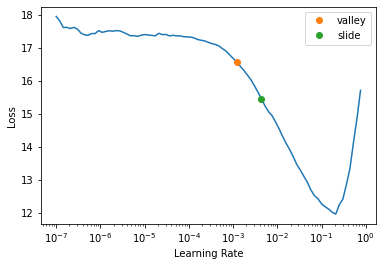

In [14]:
learn.lr_find(suggest_funcs=(valley,slide))

### Training the learner

In [15]:
learn.fine_tune(1, 0.01)

epoch,train_loss,valid_loss,usm1_loss,usm2_loss,usm3_loss,usm4_loss,usm1_err,usm2_err,usm3_err,usm4_err,combo_err,time
0,0.443698,0.297815,0.074684,0.046353,0.069933,0.106844,0.024489,0.012715,0.020915,0.032715,0.090833,1:52:10


epoch,train_loss,valid_loss,usm1_loss,usm2_loss,usm3_loss,usm4_loss,usm1_err,usm2_err,usm3_err,usm4_err,combo_err,time
0,0.028133,0.118842,0.019246,0.016584,0.033173,0.049838,0.004613,0.003222,0.007284,0.009114,0.024233,2:30:20


# Replicating the error rate & validation

### The normal combo loss

In [16]:
# validating model performance
preds_err=combo_err_raw(*learn.get_preds(dl=dls.valid))
preds_err

TensorBase(0.0242)

### The TTA loss

In [17]:
tta_err=combo_err_raw(*learn.tta(dl=dls.valid))
tta_err

TensorBase(0.0241)

# Saving the learner

In [18]:
learn.path=Path('models/cls')
learn.export('01_baseline_model.pkl')

# Exporting the module

In [28]:
nb_export('04_baseline.ipynb', '.')